In [92]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from P02_MSIE.T01_prototype_class.DE_IM_VRPTW_classV4 import VRPTW

In [93]:
class AIMH_ENV(gym.Env):
    def __init__(self, vrp):
        super().__init__()
        self.action_space = spaces.Box(
            low = np.array([0, 0, 0], dtype=np.float32), 
            high= np.array([5, 5, 1], dtype=np.float32), 
            shape=(3,),
            dtype=np.float32,
        )
            # order = [
        #     "best_solution",
        #     "F",
        #     "CR",
        #     "MG",
        #     "percent_convergence",
        #     "std_pop",
        #     "count_total_iteration",
        # ]
        self.observation_space = gym.spaces.Box(
            low=np.array([-2, 0, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([2, 10, 10, 1, 1, 1, 1e5], dtype=np.float32),
            shape=(7,),  # 7 features
            dtype=np.float64,
        )
        self.vrp = vrp
        pass


    def _get_obs(self):
        
        state = self.vrp.get_current_state()
        obs = np.array(
            [
                np.float64(state["best_solution"]),
                np.float64(state["F"]),
                np.float64(state["CR"]),
                np.float64(state["MG"]),
                np.float64(state["percent_convergence"]),
                np.float64(state["std_pop"]),
                np.float64(state["count_total_iteration"]),
            ],
            dtype=np.float32,
        )
        
        return obs
    
    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info in addition to the observation
        """
        return self.vrp.get_info()
    

    def reset(self, seed=None, options=None):
        # np.random.seed(seed or 42)
        self.vrp.reset()
        super().reset(seed=seed)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        self.vrp.action(action)
        self.vrp.evolve()
        reward = self.vrp.get_reward()
        if self.vrp.is_terminated():
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

    

In [94]:
AIMH_ENV(vrp=None).action_space.sample()

array([1.0815059 , 0.10114421, 0.22540955], dtype=float32)

In [95]:
distance = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="distance"
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="vehicle"
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"../../Source/rl_meta_test_data.xlsx", sheet_name="customer"
).iloc[:, 3:]
demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, -1].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
interval_it = 100
patience = 1000
population_size = 4
bounds = np.array([[0, 1]] * dimensions)
F_rate = 0.5
CR_rate = 0.5
MG_rate = 0.5

vrptw = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle,
    interval_it=interval_it,
    patience=patience,
)

In [96]:
# TODO: Fix the environment to pass the checks
# UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
#   logger.warn(f"{pre} is not within the observation space.")
# Environment has issues: Deterministic step observations are not equivalent for the same seed and action


from gymnasium.utils.env_checker import check_env

env = AIMH_ENV(vrp=vrptw)

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment has issues: The first element returned by `env.reset()` is not within the observation space.


c:\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\env_checker.py:333: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(


In [97]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [98]:
import pandas as pd

obs, info = env.reset()
terminated = False
truncated = False

data_array = []
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    data_added = {**info, "reward": reward, "action": action}
    data_array.append(data_added)

df = pd.DataFrame.from_dict(data_array)
display(df)

,F,CR,MG,best_solution,percent_convergence,std_pop,count_total_iteration,rw_benchmark_solution,patience_remaining,reward,action
0,0.246243,0.006548,0.394542,62.473699,66.063761,1.989721,100,"[66.68849845448665, 62.47369903896553, 60.8217...",1000,4.214799,"[0.24624288, 0.0065477192, 0.39454186]"
1,1.000000,0.002960,0.055326,60.821760,61.865481,2.100833,200,"[66.68849845448665, 62.47369903896553, 60.8217...",1000,1.651939,"[4.5461073, 0.0029599667, 0.055325925]"
2,1.000000,0.000012,0.068577,60.821760,60.213542,2.100833,300,"[66.68849845448665, 62.47369903896553, 60.8217...",900,0.000000,"[4.9958014, 1.1771917e-05, 0.06857744]"
3,1.000000,0.000010,0.603572,60.821760,60.213542,1.827831,400,"[66.68849845448665, 62.47369903896553, 60.8217...",800,0.000000,"[4.9994383, 1.4901161e-07, 0.6035719]"
4,1.000000,0.000010,0.979558,60.821760,60.213542,1.827831,500,"[66.68849845448665, 62.47369903896553, 60.8217...",700,0.000000,"[4.9999166, 0.0, 0.9795581]"
5,1.000000,0.000010,0.999438,60.821760,60.213542,1.827831,600,"[66.68849845448665, 62.47369903896553, 60.8217...",600,0.000000,"[4.9999857, 0.0, 0.9994381]"
6,1.000000,0.000010,0.999986,60.821760,60.213542,1.827831,700,"[66.68849845448665, 62.47369903896553, 60.8217...",500,0.000000,"[4.999996, 0.0, 0.9999862]"
7,1.000000,0.000010,1.000000,60.821760,60.213542,1.827831,800,"[66.68849845448665, 62.47369903896553, 60.8217...",400,0.000000,"[4.9999995, 0.0, 0.9999995]"
8,1.000000,0.000010,1.000000,60.821760,60.213542,1.827831,900,"[66.68849845448665, 62.47369903896553, 60.8217...",300,0.000000,"[5.0, 0.0, 1.0]"
9,1.000000,0.000010,1.000000,60.821760,60.213542,1.827831,1000,"[66.68849845448665, 62.47369903896553, 60.8217...",200,0.000000,"[5.0, 0.0, 1.0]"


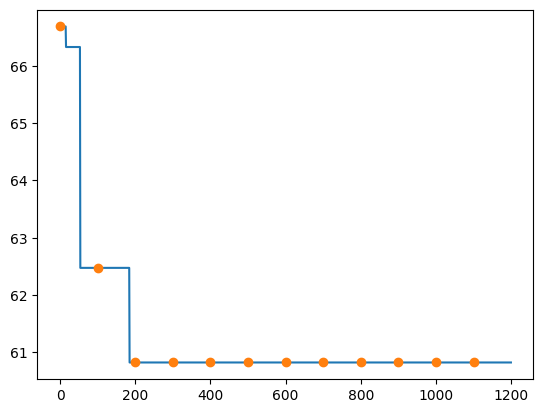

In [99]:
import matplotlib.pyplot as plt
plt.plot(env.vrp.global_solution_history)
x = np.arange(0,len(env.vrp.global_solution_history), interval_it)
y = np.array(env.vrp.global_solution_history)[x]
plt.plot(x, y, marker='o', linestyle='')


In [107]:
env.vrp.rw_benchmark_solution[1] - env.vrp.rw_benchmark_solution[2]

1.6519392840777982

In [101]:
env.vrp.global_solution_history[199]

60.82175975488773

In [102]:
env.vrp.rw_benchmark_solution

[66.68849845448665,
 62.47369903896553,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773,
 60.82175975488773]

In [103]:
y

array([66.68849845, 62.47369904, 60.82175975, 60.82175975, 60.82175975,
       60.82175975, 60.82175975, 60.82175975, 60.82175975, 60.82175975,
       60.82175975, 60.82175975])

In [104]:
x

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100])

In [105]:
rw_benchmark_solution[21]-env.vrp.global_solution_history[22]

NameError: name 'rw_benchmark_solution' is not defined